In [ ]:
#Veriyi okuma ve işleme adımında kullanılacak olan kütüphaneler
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

#Model değerlendirme ve veriyi scale edebilmemiz için kullanılacak olan kütüphaneler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#Model için kullanılacak olan kütütphaneler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Attention, Dropout, Flatten, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#Warning kapatmak için kullanılmaktadır.
import warnings
warnings.filterwarnings('ignore')

#Tensorflow Warning engelleme
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
# Veriyi okuma
df = pd.read_csv("TSLA.csv")

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [ ]:
# Veri çerçevesini inceleyen bir fonksiyon
def check_df(dataframe, head=5):
    print("####################### SHAPE #######################")
    print(dataframe.shape)
    print("####################### TYPES #######################")
    print(dataframe.dtypes)
    print("####################### HEAD #######################")
    print(dataframe.head(head))
    print("####################### TAİL #######################")
    print(dataframe.tail(head))
    print("####################### NA #######################")
    print(dataframe.isnull().sum())
    print("####################### QUANTLES #######################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


In [ ]:
# Veri çerçevesini inceleme
check_df(df)

####################### SHAPE #######################
(2956, 7)
####################### TYPES #######################
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
####################### HEAD #######################
         Date   Open   High    Low  Close  Adj Close    Volume
0  2010-06-29  3.800  5.000  3.508  4.778      4.778  93831500
1  2010-06-30  5.158  6.084  4.660  4.766      4.766  85935500
2  2010-07-01  5.000  5.184  4.054  4.392      4.392  41094000
3  2010-07-02  4.600  4.620  3.742  3.840      3.840  25699000
4  2010-07-06  4.000  4.000  3.166  3.222      3.222  34334500
####################### TAİL #######################
            Date         Open         High         Low        Close  \
2951  2022-03-18   874.489990   907.849976  867.390015   905.390015   
2952  2022-03-21   914.979980   942.849976  907.090027   921.159973   
2953  2022-03-22   930.0

In [ ]:
# Tarih sütununu datetime formatına çevirme
df["Date"] = pd.to_datetime(df["Date"])

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [ ]:
# Gerekli sütunları seçme
tesla_df = df[["Date", "Close"]]

In [ ]:
tesla_df.head()

,Date,Close
0,2010-06-29,4.778
1,2010-06-30,4.766
2,2010-07-01,4.392
3,2010-07-02,3.840
4,2010-07-06,3.222


In [ ]:
# Minimum ve maksimum tarihleri görüntüleme
print("Minimum Tarih:", tesla_df["Date"].min())
print("Maksimum Tarih:", tesla_df["Date"].max())

Minimum Tarih: 2010-06-29 00:00:00
Maksimum Tarih: 2022-03-24 00:00:00


In [ ]:
# Tarihi index olarak atama ve Date sütununu kaldırma
tesla_df.index = tesla_df["Date"]
tesla_df.drop("Date", axis=1, inplace=True)

In [ ]:
tesla_df

,Close
Date,
2010-06-29,4.778000
2010-06-30,4.766000
2010-07-01,4.392000
2010-07-02,3.840000
2010-07-06,3.222000
...,...
2022-03-18,905.390015
2022-03-21,921.159973
2022-03-22,993.979980


In [ ]:
# Kopya bir veri çerçevesi oluşturma
result_df = tesla_df.copy()

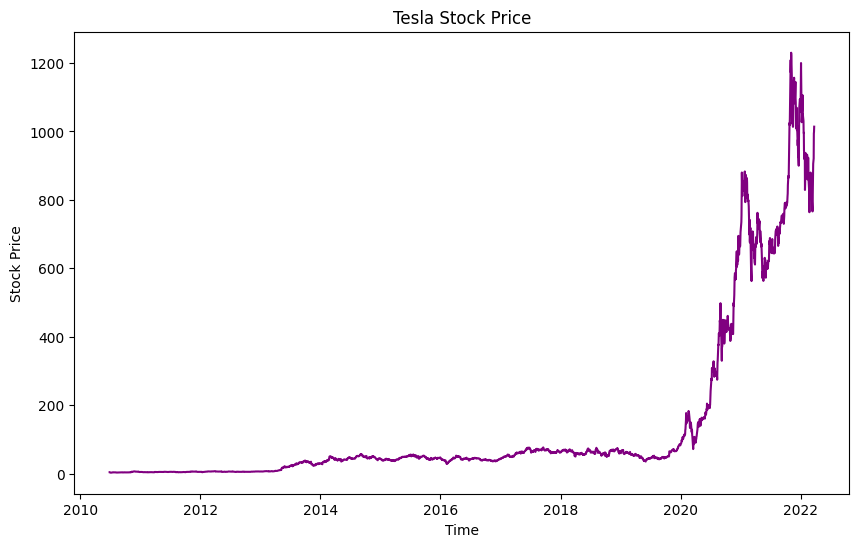

In [ ]:
# Grafiği çizme
plt.figure(figsize=(10, 6))
plt.plot(tesla_df['Close'], color='purple')
plt.ylabel('Stock Price')
plt.title('Tesla Stock Price')
plt.xlabel('Time')
plt.show()

In [ ]:
# Numpy array'e dönüştürme
tesla_df = tesla_df.values

In [ ]:
tesla_df[0:5]

array([[4.778],
       [4.766],
       [4.392],
       [3.84 ],
       [3.222]])

In [ ]:
# Sinir ağlarında yaygınca kullanılan veri yapısı float32'dir.
tesla_df = tesla_df.astype('float32')

In [ ]:
# Train-test ayrımının yapılması
def split_data(dataframe, test_size):
    pos = int(round(len(dataframe) * (1 - test_size)))
    train = dataframe[:pos]
    test = dataframe[pos:]
    return train, test, pos

In [ ]:
# Train ve test veri setlerini oluşturma
train, test, pos = split_data(tesla_df, 0.20)

In [ ]:
print(train.shape, test.shape)

(2365, 1) (591, 1)


In [ ]:
# Veriyi normalize etme
scaler_train = MinMaxScaler(feature_range=(0, 1))
train = scaler_train.fit_transform(train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
test = scaler_test.fit_transform(test)

In [ ]:
# Normalized veriyi gösterme
print(train[0:5])

[[0.02191224]
 [0.02174973]
 [0.01668473]
 [0.0092091 ]
 [0.00083965]]


In [ ]:
test[0:5]

array([[0.00525717],
       [0.00400301],
       [0.00445142],
       [0.00070783],
       [0.00127478]], dtype=float32)

In [ ]:
# Model için özellikleri oluşturma fonksiyonu
def create_features(data, lookback):
    X, Y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        Y.append(data[i, 0])

    return np.array(X), np.array(Y)

In [ ]:
#  Train ve test veri seti özellikleri oluşturma
lookback = 20
X_train, y_train = create_features(train, lookback)
X_test, y_test = create_features(test, lookback)

In [ ]:
# Oluşturulan özellikleri gösterme
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2345, 20) (2345,) (571, 20) (571,)


In [ ]:
X_train[0:5]

array([[0.02191224, 0.02174973, 0.01668473, 0.0092091 , 0.00083965,
        0.        , 0.00449621, 0.00433369, 0.0033857 , 0.00633803,
        0.01094258, 0.01107801, 0.01310942, 0.0165493 , 0.01218852,
        0.01197184, 0.01408451, 0.01486999, 0.01394908, 0.01286566],
       [0.02174973, 0.01668473, 0.0092091 , 0.00083965, 0.        ,
        0.00449621, 0.00433369, 0.0033857 , 0.00633803, 0.01094258,
        0.01107801, 0.01310942, 0.0165493 , 0.01218852, 0.01197184,
        0.01408451, 0.01486999, 0.01394908, 0.01286566, 0.01332611],
       [0.01668473, 0.0092091 , 0.00083965, 0.        , 0.00449621,
        0.00433369, 0.0033857 , 0.00633803, 0.01094258, 0.01107801,
        0.01310942, 0.0165493 , 0.01218852, 0.01197184, 0.01408451,
        0.01486999, 0.01394908, 0.01286566, 0.01332611, 0.01232395],
       [0.0092091 , 0.00083965, 0.        , 0.00449621, 0.00433369,
        0.0033857 , 0.00633803, 0.01094258, 0.01107801, 0.01310942,
        0.0165493 , 0.01218852, 0.01197184, 0

In [ ]:
y_train[0:5]

array([0.01332611, 0.01232395, 0.01121343, 0.01386782, 0.01665764],
      dtype=float32)

In [ ]:
# Verileri LSTM modeli için uygun şekle getirme
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Hedefleri uygun şekle getirme
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Şekilleri kontrol etme
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2345, 1, 20)
y_train shape: (2345, 1)
X_test shape: (571, 1, 20)
y_test shape: (571, 1)


In [ ]:
# MODELLEME
# Model oluşturma
inputs = Input(shape=(1, lookback))
lstm_out, state_h, state_c = LSTM(units=50, return_state=True, return_sequences=True)(inputs)

# Attention mekanizması
attention = Attention()([lstm_out, lstm_out])
context = attention * lstm_out
context = Flatten()(context)

# Dropout ekleyin
context_with_dropout = Dropout(0.2)(context)

# Yineleme katmanları
repeat_context = RepeatVector(lookback)(context_with_dropout)
lstm_out_repeat = LSTM(units=50, return_sequences=True)(repeat_context)

# State_h_repeat boyutunu düzeltme
state_h_repeat = RepeatVector(lookback)(state_h)

# Birleştirme
merged = Concatenate(axis=-1)([state_h_repeat, lstm_out_repeat])

# Tam bağlı katman
dense_out = Dense(1)(merged)

# Model
model = Model(inputs=inputs, outputs=dense_out)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1, 20)]              0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 1, 50),              14200     ['input_1[0][0]']             
                              (None, 50),                                                         
                              (None, 50)]                                                         
                                                                                                  
 attention (Attention)       (None, 1, 50)                0         ['lstm[0][0]',                
                                                                     'lstm[0][0]']            

In [ ]:
# OPTİMİZASYON VE DEĞERLENDİRME METRİKLERİ AYARLANMASI
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# Callback'leri ayarlama
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode="min"),
             ModelCheckpoint(filepath='mymodel.h5', monitor='val_loss', mode='min',
                             save_best_only=True, save_weights_only=False, verbose=1)]


In [ ]:
# Modeli eğitme
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=100,
                    batch_size=20,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks,
                    shuffle=False)

Epoch 1/100
117/118 [============================>.] - ETA: 0s - loss: 0.0050
Epoch 1: val_loss improved from inf to 0.00604, saving model to mymodel.h5
118/118 [==============================] - 18s 15ms/step - loss: 0.0051 - val_loss: 0.0060
Epoch 2/100
112/118 [===========================>..] - ETA: 0s - loss: 0.0033
Epoch 2: val_loss improved from 0.00604 to 0.00263, saving model to mymodel.h5
118/118 [==============================] - 1s 8ms/step - loss: 0.0034 - val_loss: 0.0026
Epoch 3/100
118/118 [==============================] - ETA: 0s - loss: 0.0019
Epoch 3: val_loss improved from 0.00263 to 0.00258, saving model to mymodel.h5
118/118 [==============================] - 1s 11ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 4/100
118/118 [==============================] - ETA: 0s - loss: 0.0017
Epoch 4: val_loss improved from 0.00258 to 0.00253, saving model to mymodel.h5
118/118 [==============================] - 1s 12ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 5/100
116/

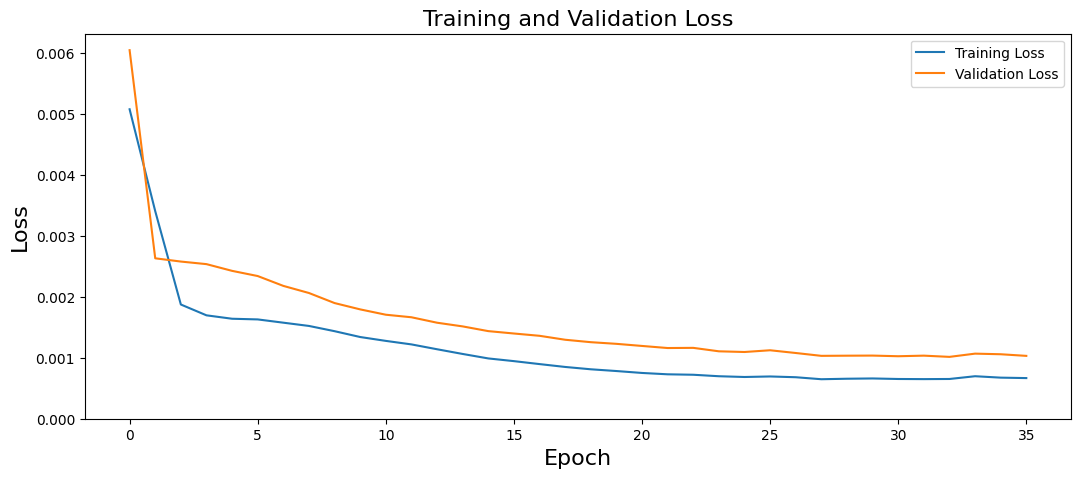

In [ ]:
# Eğitim ve doğrulama kayıplarını görselleştirme
plt.figure(figsize=(28, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)
plt.show()


In [ ]:
#MODEL DEĞERLENDİRME
loss=model.evaluate(X_test, y_test,batch_size=20)
print("\nText loss: %.2f%%"%(100.0*loss))

29/29 [==============================] - 0s 4ms/step - loss: 0.0010

Text loss: 0.10%


In [ ]:
# Modelin  train ve test verileri üzerinde tahminleri
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

18/18 [==============================] - 0s 5ms/step


In [ ]:
# Veriyi tersine çevirme
train_predict = train_predict.reshape(-1, 1)
test_predict = test_predict.reshape(-1, 1)

# Dönüşümü gerçekleştirme
train_predict_inverse = scaler_train.inverse_transform(train_predict)
test_predict_inverse = scaler_test.inverse_transform(test_predict)
y_train_inverse = scaler_train.inverse_transform(y_train)
y_test_inverse = scaler_test.inverse_transform(y_test)

# Tahmin kümesini gerçek değerlerin boyutuna uygun hale getirme
train_predict_inverse = train_predict_inverse[:len(y_train_inverse)]
test_predict_inverse = test_predict_inverse[:len(y_test_inverse)]

# Train ve Test RMSE değerleri
train_rmse = np.sqrt(mean_squared_error(y_train_inverse, train_predict_inverse))
test_rmse = np.sqrt(mean_squared_error(y_test_inverse, test_predict_inverse))
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")


Train RMSE: 39.41817092895508
Test RMSE: 576.50390625


In [ ]:
# Train veri setindeki belirli bir aralıktaki gerçek değerlerle modelin tahmin ettiği sonuçları içeren bir veriler
train_prediction_df = result_df[lookback:pos]
print("Length of train_predict:", len(train_predict))
train_prediction_df.head()


Length of train_predict: 46900


,Close
Date,
2010-07-28,4.144
2010-07-29,4.070
2010-07-30,3.988
2010-08-02,4.184
2010-08-03,4.390


In [ ]:
#test veri setindeki belirli bir aralıktaki gerçek değerlerle modelin tahmin ettiği sonuçları içeren bir veriler
test_prediction_df=result_df[pos+lookback:]
print("Length of test_predict:", len(test_predict))
test_prediction_df.head()

Length of test_predict: 11420


,Close
Date,
2019-12-18,78.629997
2019-12-19,80.807999
2019-12-20,81.117996
2019-12-23,83.844002
2019-12-24,85.050003


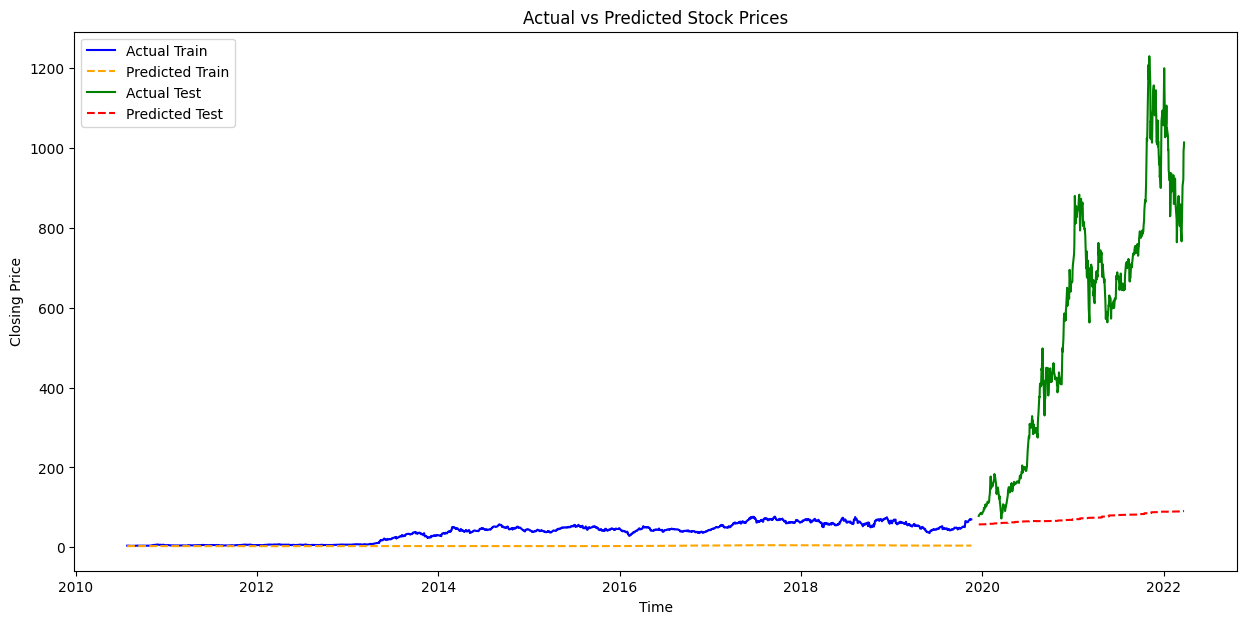

In [ ]:
# Gerçek ve tahmin edilen verileri içeren bir veri çerçevesi oluşturma
train_prediction_df["Train Predictions"] = train_predict_inverse
test_prediction_df = result_df.iloc[pos+lookback:]
test_prediction_df["Test Predictions"] = test_predict_inverse

# Grafiği çizme
plt.figure(figsize=(15, 7))

# Eğitim verileri
plt.plot(train_prediction_df.index, train_prediction_df["Close"], label='Actual Train', color='blue')
plt.plot(train_prediction_df.index, train_prediction_df["Train Predictions"], label='Predicted Train', linestyle='dashed', color='orange')

# Test verileri
plt.plot(test_prediction_df.index, test_prediction_df["Close"], label='Actual Test', color='green')
plt.plot(test_prediction_df.index, test_prediction_df["Test Predictions"], label='Predicted Test', linestyle='dashed', color='red')

# Grafik özellikleri
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()